### Compare Listing 
<ol>
<li>a: vector uniform</li>
<li>b: greedy</li>
<li>c: e - greedy</li>
<li>d: decay e - greedy</li>
<li>e: Linear Reward Inaction (Pursuit Methods)</li>
<li>f: Linear Reward Penalty (Pursuit Methods)</li>
<li>g: UBC 1</li>
<li>h: UCB 1-Tuned</li>
<li>i: Thompson Sampling (beta)</li>
<li>j: Thompson Sampling (uniform)</li>
<li>k: Neural Network</li>
<li>l: softmax </li>
<li>m: Gradient Bandits</li>
</ol>

In [233]:
# import lib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy,time,sys
import scipy.stats as stats
from scipy.stats import beta
plt.style.use('seaborn')
np.random.seed(5678)
np.set_printoptions(3)
tf.set_random_seed(678)
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [3]:
# setting the ground truth
num_bandit = 12
num_ep  = 20
num_iter= 1000
gt_prob = np.random.uniform(0,1,num_bandit)
optimal_choice = np.argmax(gt_prob)
print(gt_prob)
print('Best Choice: ',optimal_choice,gt_prob[optimal_choice])

[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736]
Best Choice:  11 0.7364685816073836


In [19]:
# a vectorized
a_expect = np.zeros((num_ep,num_bandit))
                    
for eps in range(num_ep):
    temp_expect = np.zeros(num_bandit)
    temp_choice = np.zeros(num_bandit)
                    
    for iter in range(num_iter//10):
        temp_choice    = temp_choice + 1
        current_reward = np.random.uniform(0,1,num_bandit) < gt_prob
        temp_expect    = temp_expect + current_reward

    a_expect[eps,:] = temp_expect/temp_choice
                    
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(a_expect.mean(0))

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736]
Expected 
[0.481 0.057 0.354 0.528 0.599 0.423 0.17  0.275 0.084 0.182 0.084 0.758]


In [67]:
# b greedy
b_pull_count   = np.zeros((num_ep,num_bandit))
b_estimation   = np.zeros((num_ep,num_bandit))
b_reward       = np.zeros((num_ep,num_iter))
b_optimal_pull = np.zeros((num_ep,num_iter))
b_regret_total = np.zeros((num_ep,num_iter))
                    
for eps in range(num_ep):
    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit)
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
    temp_regret = np.zeros(num_iter)
                    
    for iter in range(num_iter):
        
        # select bandit / get reward /increase count / update estimate
        current_choice = np.argmax(temp_estimation)
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        temp_estimation[current_choice] = temp_estimation[current_choice] + (1/(temp_pull_count[current_choice]+1)) * (current_reward-temp_estimation[current_choice])
        
        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
    b_pull_count[eps,:]   = temp_pull_count
    b_estimation[eps,:]   = temp_estimation
    b_reward[eps,:]       = temp_reward
    b_optimal_pull[eps,:] = temp_optimal_pull
    b_regret_total[eps,:] = temp_regret
        
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(b_estimation.mean(0))

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736]
Expected 
[0.484 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]


In [68]:
# c e greedy 
c_pull_count   = np.zeros((num_ep,num_bandit))
c_estimation   = np.zeros((num_ep,num_bandit))
c_reward       = np.zeros((num_ep,num_iter))
c_optimal_pull = np.zeros((num_ep,num_iter))
c_regret_total = np.zeros((num_ep,num_iter))
                    
for eps in range(num_ep):
    epsilon = np.random.uniform(0,1)
    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit)
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
    temp_regret = np.zeros(num_iter)
  
    for iter in range(num_iter):
        
        # select bandit / get reward /increase count / update estimate
        current_choice = np.argmax(temp_expect) if epsilon < np.random.uniform(0,1) else np.random.choice(np.arange(num_bandit))
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        temp_estimation[current_choice] = temp_estimation[current_choice] + (1/(temp_pull_count[current_choice]+1)) * (current_reward-temp_estimation[current_choice])
        
        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
    c_pull_count[eps,:]   = temp_pull_count
    c_estimation[eps,:]   = temp_estimation
    c_reward[eps,:]       = temp_reward
    c_optimal_pull[eps,:] = temp_optimal_pull
    c_regret_total[eps,:] = temp_regret
        
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(c_estimation.mean(0))

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736]
Expected 
[0.461 0.049 0.316 0.513 0.577 0.401 0.164 0.244 0.071 0.184 0.074 0.734]


In [80]:
# d decy e greedy 
d_pull_count   = np.zeros((num_ep,num_bandit))
d_estimation   = np.zeros((num_ep,num_bandit))
d_reward       = np.zeros((num_ep,num_iter))
d_optimal_pull = np.zeros((num_ep,num_iter))
d_regret_total = np.zeros((num_ep,num_iter))

for eps in range(num_ep):
    epsilon = 1.0
    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit)
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
                    
    for iter in range(num_iter):
        
        # select bandit / get reward /increase count / update estimate
        current_choice = np.argmax(temp_expect) if epsilon < np.random.uniform(0,1) else np.random.choice(np.arange(num_bandit))
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        temp_estimation[current_choice] = temp_estimation[current_choice] + (1/(temp_pull_count[current_choice]+1)) * (current_reward-temp_estimation[current_choice])
        
        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
        # decay the eps
        epsilon = 0.99 * epsilon
        
    d_pull_count[eps,:]   = temp_pull_count
    d_estimation[eps,:]   = temp_estimation
    d_reward[eps,:]       = temp_reward
    d_optimal_pull[eps,:] = temp_optimal_pull
    d_regret_total[eps,:] = temp_regret
        
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(d_estimation.mean(0))

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736]
Expected 
[0.436 0.018 0.359 0.438 0.487 0.39  0.155 0.221 0.034 0.118 0.076 0.734]


In [94]:
# e Linear Reward Inaction
e_pull_count   = np.zeros((num_ep,num_bandit))
e_estimation   = np.zeros((num_ep,num_bandit))
e_reward       = np.zeros((num_ep,num_iter))
e_optimal_pull = np.zeros((num_ep,num_iter))
e_regret_total = np.zeros((num_ep,num_iter))
      
for eps in range(num_ep):
    learning_rate = 0.1
    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit) + 1.0/num_bandit
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
    
    for iter in range(num_iter):
        
        # select bandit / get reward /increase count / update estimate
        current_choice = np.random.choice(num_bandit, p=temp_estimation)
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        
        mask = np.zeros(num_bandit)
        mask[current_choice] = 1.0
        
        if current_reward == 1.0:
            temp_estimation = (mask) * (temp_estimation + learning_rate * (1-temp_estimation)) + (1-mask) * ( (1-learning_rate) * temp_estimation)
            
        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
    e_pull_count[eps,:]   = temp_pull_count
    e_estimation[eps,:]   = temp_estimation
    e_reward[eps,:]       = temp_reward
    e_optimal_pull[eps,:] = temp_optimal_pull
    e_regret_total[eps,:] = temp_regret
        
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(np.around(e_estimation.mean(0),3))
print('Expected Normalized')
print(np.around(e_estimation.mean(0),3)* gt_prob.sum())

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736]
Expected 
[0.   0.   0.   0.1  0.2  0.05 0.   0.   0.   0.   0.   0.65]
Expected Normalized
[0.    0.    0.    0.401 0.801 0.2   0.    0.    0.    0.    0.    2.604]


In [105]:
# f Linear Reward Penalty
f_pull_count   = np.zeros((num_ep,num_bandit))
f_estimation   = np.zeros((num_ep,num_bandit))
f_reward       = np.zeros((num_ep,num_iter))
f_optimal_pull = np.zeros((num_ep,num_iter))
f_regret_total = np.zeros((num_ep,num_iter))
                    
for eps in range(num_ep):
    alpha = 0.01
    beta  = 0.001
    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit) + 1.0/num_bandit
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
    
    for iter in range(num_iter):

        # select bandit / get reward /increase count / update estimate
        current_choice = np.random.choice(num_bandit, p=temp_estimation)
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1

        mask = np.zeros(num_bandit)
        mask[current_choice] = 1.0
        
        if current_reward == 1.0:
            temp_estimation = (mask) * (temp_estimation + alpha * (1-temp_estimation)) + (1-mask) * ( (1-alpha) * temp_estimation)
        else: 
            temp_estimation = (mask) * ((1-beta) * temp_estimation) + (1-mask) * ( beta/(num_bandit-1) + (1-beta) * temp_estimation )

        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
    f_pull_count[eps,:]   = temp_pull_count
    f_estimation[eps,:]   = temp_estimation
    f_reward[eps,:]       = temp_reward
    f_optimal_pull[eps,:] = temp_optimal_pull
    f_regret_total[eps,:] = temp_regret
    
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(f_estimation.mean(0))
print('Expected Normalized')
print(
    (f_estimation-f_estimation.min())/(f_estimation.max()-f_estimation.min())
)

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736]
Expected 
[0.057 0.007 0.031 0.08  0.15  0.037 0.008 0.017 0.007 0.009 0.006 0.591]
Expected Normalized
[0.229 0.028 0.124 0.319 0.6   0.147 0.034 0.069 0.026 0.036 0.026 2.37 ]


In [112]:
# g UBC 1
g_pull_count   = np.zeros((num_ep,num_bandit))
g_estimation   = np.zeros((num_ep,num_bandit))
g_reward       = np.zeros((num_ep,num_iter))
g_optimal_pull = np.zeros((num_ep,num_iter))
g_regret_total = np.zeros((num_ep,num_iter))

for eps in range(num_ep):
    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit)
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
                    
    for iter in range(num_iter):
        
        # select bandit / get reward /increase count / update estimate
        current_choice = np.argmax(temp_estimation + np.sqrt(0.5*np.log(iter+1)/(temp_pull_count+1)))
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        temp_estimation[current_choice] = temp_estimation[current_choice] + (1/(temp_pull_count[current_choice]+1)) * (current_reward-temp_estimation[current_choice])
        
        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
    g_pull_count[eps,:]   = temp_pull_count
    g_estimation[eps,:]   = temp_estimation
    g_reward[eps,:]       = temp_reward
    g_optimal_pull[eps,:] = temp_optimal_pull
    g_regret_total[eps,:] = temp_regret
  
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(g_estimation.mean(0))

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736]
Expected 
[0.429 0.033 0.277 0.414 0.556 0.404 0.115 0.17  0.037 0.164 0.077 0.732]


In [157]:
# h UBC 1 Tuned
h_pull_count   = np.zeros((num_ep,num_bandit))
h_estimation   = np.zeros((num_ep,num_bandit))
h_reward       = np.zeros((num_ep,num_iter))
h_optimal_pull = np.zeros((num_ep,num_iter))
h_regret_total = np.zeros((num_ep,num_iter))

for eps in range(num_ep):
    temp_pull_count   = np.zeros(num_bandit) 
    temp_estimation   = np.zeros(num_bandit) 
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
    temp_sumof_squares= np.zeros(num_bandit)
                    
    for iter in range(num_iter):
        
        v_temp = temp_sumof_squares + np.sqrt(2*np.log(iter+1)/(temp_pull_count+1))
        current_min_value = np.minimum(v_temp,np.ones_like(v_temp)*0.25)
        # select bandit / get reward /increase count / update estimate
        current_choice = np.argmax(temp_estimation + np.sqrt(np.log(iter+1)/(temp_pull_count+1)*current_min_value))
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        temp_estimation[current_choice] = temp_estimation[current_choice] + (1/(temp_pull_count[current_choice]+1)) * (current_reward-temp_estimation[current_choice])
        
        temp_sumof_squares[current_choice] = temp_sumof_squares[current_choice] + current_reward ** 2

        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
    h_pull_count[eps,:]   = temp_pull_count
    h_estimation[eps,:]   = temp_estimation
    h_reward[eps,:]       = temp_reward
    h_optimal_pull[eps,:] = temp_optimal_pull
    h_regret_total[eps,:] = temp_regret
    
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(h_estimation.mean(0))

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736]
Expected 
[0.318 0.008 0.258 0.254 0.425 0.27  0.099 0.134 0.042 0.057 0.043 0.709]


In [116]:
# i Thompson Sampling (beta) (slow)
i_pull_count   = np.zeros((num_ep,num_bandit))
i_estimation   = np.zeros((num_ep,num_bandit))
i_reward       = np.zeros((num_ep,num_iter))
i_optimal_pull = np.zeros((num_ep,num_iter))
i_regret_total = np.zeros((num_ep,num_iter))

for eps in range(num_ep):

    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit)
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
                    
    for iter in range(num_iter):
        
        theta_samples = [stats.beta(a=1+w,b=1+t-w).rvs(size=1) for t, w in zip(temp_pull_count, temp_estimation)]
        
        # select bandit / get reward /increase count / update estimate
        current_choice = np.argmax(theta_samples)
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        temp_estimation[current_choice] = temp_estimation[current_choice] + current_reward
        
        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
    i_pull_count[eps,:]   = temp_pull_count
    i_estimation[eps,:]   = theta_samples
    i_reward[eps,:]       = temp_reward
    i_optimal_pull[eps,:] = temp_optimal_pull
    i_regret_total[eps,:] = temp_regret
        
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(i_estimation.mean(0))

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736]
Expected 
[0.462 0.2   0.312 0.394 0.545 0.35  0.203 0.33  0.14  0.247 0.253 0.735]


In [117]:
# j Thompson Sampling (uniform) (slow)
j_pull_count   = np.zeros((num_ep,num_bandit))
j_estimation   = np.zeros((num_ep,num_bandit))
j_reward       = np.zeros((num_ep,num_iter))
j_optimal_pull = np.zeros((num_ep,num_iter))
j_regret_total = np.zeros((num_ep,num_iter))

for eps in range(num_ep):

    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit)
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
                    
    for iter in range(num_iter):
        
        theta_samples = [stats.uniform(w/(t+0.000000001),1-w/(t+0.000000001)).rvs(size=1) for t, w in zip(temp_pull_count, temp_estimation)]
        
        # select bandit / get reward /increase count / update estimate
        current_choice = np.argmax(theta_samples)
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        temp_estimation[current_choice] = temp_estimation[current_choice] + current_reward
        
        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
    j_pull_count[eps,:]   = temp_pull_count
    j_estimation[eps,:]   = theta_samples
    j_reward[eps,:]       = temp_reward
    j_optimal_pull[eps,:] = temp_optimal_pull
    j_regret_total[eps,:] = temp_regret
        
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(j_estimation.mean(0))

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736]
Expected 
[0.736 0.586 0.753 0.754 0.722 0.687 0.487 0.602 0.474 0.703 0.435 0.879]


In [252]:
# k neural network (with adam)
k_pull_count   = np.zeros((num_ep,num_bandit))
k_estimation   = np.zeros((num_ep,num_bandit))
k_reward       = np.zeros((num_ep,num_iter))
k_optimal_pull = np.zeros((num_ep,num_iter))
k_regret_total = np.zeros((num_ep,num_iter))

def sigmoid(x): return 1/(1+np.exp(-x))
def d_sigmoid(x): return sigmoid(x)*(1-sigmoid(x))

for eps in range(num_ep):
    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit)
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
    
    weights = np.random.randn(num_bandit,1)
    moment  = np.zeros_like(weights); 
    velocity = np.zeros_like(weights);
    epsilon  = 0.3

    for iter in range(num_iter):
        
        # select bandit / get reward /increase count / update estimate
        if np.random.uniform(0,1)>epsilon:
            current_choice = np.argmax(weights)
            current_input  = np.zeros((1,num_bandit))
            current_input[0,current_choice] = 1
        else:
            current_choice = np.random.choice(np.arange(num_bandit))
            current_input  = np.zeros((1,num_bandit))
            current_input[0,current_choice] = 1

        layer1 = current_input @ weights
        layer1a= sigmoid(layer1)

        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_estimation[current_choice] = temp_estimation[current_choice] + current_reward
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        
        # KL Divergence https://timvieira.github.io/blog/post/2014/10/06/kl-divergence-as-an-objective-function/
        grad3 = np.log(layer1a+0.0000001) - np.log(temp_estimation[current_choice]/(temp_pull_count[current_choice])+0.0000001)
        grad2 = d_sigmoid(layer1)
        grad1 = current_input
        grad  = grad1.T @ (grad3 * grad2)
        
        moment   = 0.9*moment + (1-0.9) * grad
        velocity = 0.999*velocity + (1-0.999) * grad**2
        moment_hat   = moment/(1-0.9)
        velocity_hat = velocity/(1-0.999)
        weights  = weights - 0.08 * (moment_hat/(np.sqrt(velocity_hat)+1e-8))

        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
        # Decay the learning rate
        epsilon = epsilon * 0.999
        
    k_pull_count[eps,:]   = temp_pull_count
    k_estimation[eps,:]   = np.squeeze(sigmoid(weights))
    k_reward[eps,:]       = temp_reward
    k_optimal_pull[eps,:] = temp_optimal_pull
    k_regret_total[eps,:] = temp_regret
        
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(k_estimation.mean(0))

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736]
Expected 
[0.37  0.094 0.312 0.447 0.48  0.351 0.192 0.256 0.068 0.16  0.118 0.673]


In [185]:
# l softmax
l_pull_count   = np.zeros((num_ep,num_bandit))
l_estimation   = np.zeros((num_ep,num_bandit))
l_reward       = np.zeros((num_ep,num_iter))
l_optimal_pull = np.zeros((num_ep,num_iter))
l_regret_total = np.zeros((num_ep,num_iter))
                    
for eps in range(num_ep):
    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit)
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
    temp_regret = np.zeros(num_iter)
    tempture = 30
                    
    for iter in range(num_iter):
        
        # select bandit / get reward /increase count / update estimate
        pi  = np.exp(temp_estimation/tempture) / np.sum(np.exp(temp_estimation/tempture))
        current_choice = np.random.choice(num_bandit,p=pi)
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        temp_estimation[current_choice] = temp_estimation[current_choice] + (1/(temp_pull_count[current_choice]+1)) * (current_reward-temp_estimation[current_choice])

        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
        # decay the temp
        tempture = tempture * 0.99
        
    l_pull_count[eps,:]   = temp_pull_count
    l_estimation[eps,:]   = temp_estimation
    l_reward[eps,:]       = temp_reward
    l_optimal_pull[eps,:] = temp_optimal_pull
    l_regret_total[eps,:] = temp_regret
        
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(l_estimation.mean(0))

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736]
Expected 
[0.495 0.074 0.343 0.513 0.592 0.402 0.175 0.275 0.073 0.165 0.074 0.73 ]


In [230]:
# m gradient base
m_pull_count   = np.zeros((num_ep,num_bandit))
m_estimation   = np.zeros((num_ep,num_bandit))
m_reward       = np.zeros((num_ep,num_iter))
m_optimal_pull = np.zeros((num_ep,num_iter))
m_regret_total = np.zeros((num_ep,num_iter))
                    
for eps in range(num_ep):
    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit)
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
    temp_regret = np.zeros(num_iter)
    temp_mean_reward = 0
    alpha = np.random.uniform(0.5,1)
                    
    for iter in range(num_iter):
        
        # select bandit / get reward /increase count / update estimate
        pi  = np.exp(temp_estimation) / np.sum(np.exp(temp_estimation))
        current_choice = np.random.choice(num_bandit,p=pi)
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        
        temp_mean_reward = temp_mean_reward + ((current_reward-temp_mean_reward)+1)/(iter+1)
        mask = np.zeros(num_bandit)
        mask[current_choice] = 1
        
        temp_estimation = (mask)   * (temp_estimation+alpha*(current_reward-temp_mean_reward)*(1-pi)) + \
                          (1-mask) * (temp_estimation-alpha*(current_reward-temp_mean_reward)*(pi))

        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
    m_pull_count[eps,:]   = temp_pull_count
    m_estimation[eps,:]   = np.exp(temp_estimation) / np.sum(np.exp(temp_estimation))
    m_reward[eps,:]       = temp_reward
    m_optimal_pull[eps,:] = temp_optimal_pull
    m_regret_total[eps,:] = temp_regret
        
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(np.around(m_estimation.mean(0),3))

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736]
Expected 
[0.    0.    0.05  0.05  0.199 0.099 0.    0.    0.    0.    0.    0.599]


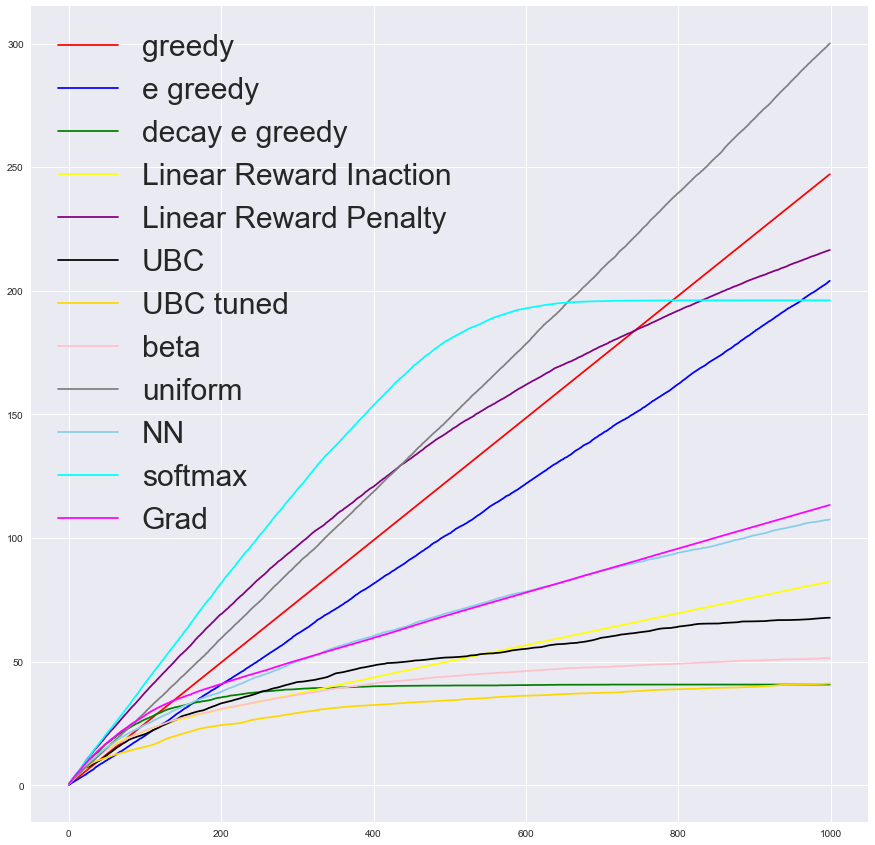

In [256]:
# plot the regret
plt.figure(figsize=(15,15))
plt.plot(b_regret_total.mean(0),c='red',    label='greedy')
plt.plot(c_regret_total.mean(0),c='blue',   label='e greedy')
plt.plot(d_regret_total.mean(0),c='green',  label='decay e greedy')
plt.plot(e_regret_total.mean(0),c='yellow', label='Linear Reward Inaction')
plt.plot(f_regret_total.mean(0),c='purple', label='Linear Reward Penalty')
plt.plot(g_regret_total.mean(0),c='black',  label='UBC')
plt.plot(h_regret_total.mean(0),c='gold',   label='UBC tuned')
plt.plot(i_regret_total.mean(0),c='pink',   label='beta')
plt.plot(j_regret_total.mean(0),c='grey',   label='uniform')
plt.plot(k_regret_total.mean(0),c='skyblue',label='NN')
plt.plot(l_regret_total.mean(0),c='cyan',   label='softmax')
plt.plot(m_regret_total.mean(0),c='magenta',label='Grad')
plt.legend(prop={'size': 30})
plt.show()

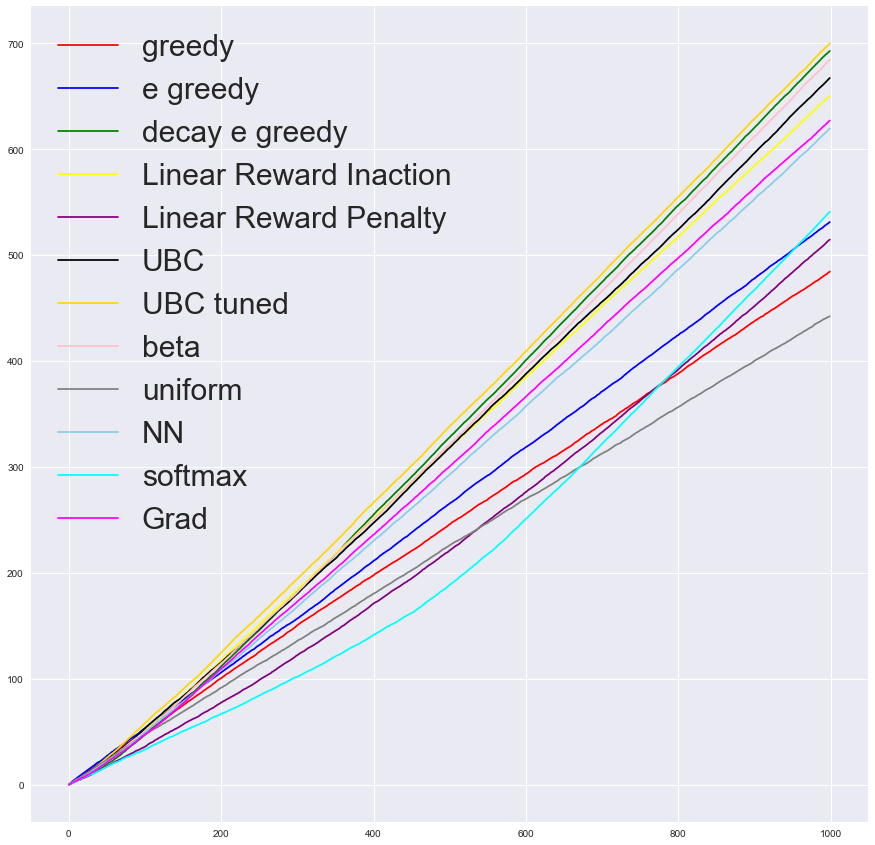

In [257]:
# plot the reward
plt.figure(figsize=(15,15))
plt.plot(b_reward.mean(0),c='red',    label='greedy')
plt.plot(c_reward.mean(0),c='blue',   label='e greedy')
plt.plot(d_reward.mean(0),c='green',  label='decay e greedy')
plt.plot(e_reward.mean(0),c='yellow', label='Linear Reward Inaction')
plt.plot(f_reward.mean(0),c='purple', label='Linear Reward Penalty')
plt.plot(g_reward.mean(0),c='black',  label='UBC')
plt.plot(h_reward.mean(0),c='gold',   label='UBC tuned')
plt.plot(i_reward.mean(0),c='pink',   label='beta')
plt.plot(j_reward.mean(0),c='grey',   label='uniform')
plt.plot(k_reward.mean(0),c='skyblue',label='NN')
plt.plot(l_reward.mean(0),c='cyan',   label='softmax')
plt.plot(m_reward.mean(0),c='magenta',label='Grad')
plt.legend(prop={'size': 30})
plt.show()

In [281]:
# plot the reward
print(gt_prob)
print(b_estimation.mean(0))
print(c_estimation.mean(0))
print(d_estimation.mean(0))
print(np.around(e_estimation.mean(0),3))
print(f_estimation.mean(0))
print(g_estimation.mean(0))
print(h_estimation.mean(0))
print(i_estimation.mean(0))
print(j_estimation.mean(0))
print(k_estimation.mean(0))
print(l_estimation.mean(0))
print(np.around(m_estimation.mean(0),3))


[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736]
[0.484 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.461 0.049 0.316 0.513 0.577 0.401 0.164 0.244 0.071 0.184 0.074 0.734]
[0.436 0.018 0.359 0.438 0.487 0.39  0.155 0.221 0.034 0.118 0.076 0.734]
[0.   0.   0.   0.1  0.2  0.05 0.   0.   0.   0.   0.   0.65]
[0.057 0.007 0.031 0.08  0.15  0.037 0.008 0.017 0.007 0.009 0.006 0.591]
[0.429 0.033 0.277 0.414 0.556 0.404 0.115 0.17  0.037 0.164 0.077 0.732]
[0.318 0.008 0.258 0.254 0.425 0.27  0.099 0.134 0.042 0.057 0.043 0.709]
[0.462 0.2   0.312 0.394 0.545 0.35  0.203 0.33  0.14  0.247 0.253 0.735]
[0.736 0.586 0.753 0.754 0.722 0.687 0.487 0.602 0.474 0.703 0.435 0.879]
[0.37  0.094 0.312 0.447 0.48  0.351 0.192 0.256 0.068 0.16  0.118 0.673]
[0.495 0.074 0.343 0.513 0.592 0.402 0.175 0.275 0.073 0.165 0.074 0.73 ]
[0.    0.    0.05  0.05  0.199 0.099 0.    0.    0.    0.    0.    0.599]


# Reference 
1. numpy.set_printoptions — NumPy v1.14 Manual. (2019). Docs.scipy.org. Retrieved 13 January 2019, from https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.set_printoptions.html
2. [ Archived Post ] Random Note about Multi-Arm Bandit Problem 2. (2019). Medium. Retrieved 13 January 2019, from https://medium.com/@SeoJaeDuk/archived-post-random-note-about-multi-arm-bandit-problem-2-5c522d1dfbdc
3. Vieira, T. (2014). KL-divergence as an objective function — Graduate Descent. Timvieira.github.io. Retrieved 13 January 2019, from https://timvieira.github.io/blog/post/2014/10/06/kl-divergence-as-an-objective-function/
4. Some Reinforcement Learning: The Greedy and Explore-Exploit Algorithms for the Multi-Armed Bandit Framework in Python. (2019). Datasciencecentral.com. Retrieved 13 January 2019, from https://www.datasciencecentral.com/profiles/blogs/some-reinforcement-learning-the-greedy-and-explore-exploit
5. (2019). Cs.mcgill.ca. Retrieved 13 January 2019, from https://www.cs.mcgill.ca/~vkules/bandits.pdf
